# Time Series Stationarity
In this note book, I investigate the stationarity of the timeseries. There are time series modelling techniques which 
do not require the data to be stationary (e.g., RNN, or expotential smoothing). However, many useful and established forecasting techniques require the data to be stationary. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import signal
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

# Utility functions

In [2]:
def PlotTs(TsVal,Rolling=12, fs=12):
    """
    Plot various characteristics of the time series 
    TsVal: time series data, pandas series
    Rolling: rolling wndow size
    """
    TsVal = TsVal.dropna()
    TsVal.reset_index(drop=True, inplace=True)    
    
    # sampling frequency 12 mo/yr default
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.4)    
    
    ax_ts = plt.subplot(grid[0,:])
    ax_acf = plt.subplot(grid[1,0])
    ax_pacf = plt.subplot(grid[1,1])
    ax_hist = plt.subplot(grid[2,0])
    ax_frq = plt.subplot(grid[2,1])
        
    ax_ts.plot(TsVal, 'b', label='time series data')
    ax_ts.plot(TsVal.rolling(Rolling).mean(), color='r', label='Rolling mean')
    ax_ts.plot(TsVal.rolling(Rolling).std(), color='g', label='Rolling std')    

    ax_ts.set_xlabel('index')
    ax_ts.set_ylabel('Percent')
    ax_ts.legend()
    
    sm.tsa.graphics.plot_acf(TsVal,ax_acf)
    sm.tsa.graphics.plot_pacf(TsVal,ax_pacf)
    
    ax_hist.hist(TsVal);
    ax_hist.set_title('histogram')
    
    f, Pxx_den = signal.periodogram(TsVal, 12,detrend=False)
    #ax_frq.semilogy(f, Pxx_den)   
    ax_frq.stem(f, 10*np.log10(Pxx_den))
    ax_frq.set_title('Periodogram')
    ax_frq.set_xlabel('frequency')
    ax_frq.set_ylabel('power density (dB/Hz)')

In [3]:
def PlotDiagnostics(Residu):
    """
    Plot diagnostics.
    """
    fig = plt.figure(figsize=(12,8))
    grid = plt.GridSpec(2,2, wspace=0.4, hspace=0.4)
    
    ax_resid = plt.subplot(grid[0,0])
    ax_hist = plt.subplot(grid[0,1])
    ax_qq = plt.subplot(grid[1,0])
    ax_acf = plt.subplot(grid[1,1])
    
    ax_resid.plot(Residu)
    ax_resid.set_xlabel('index')
    ax_resid.set_ylabel('residual')
    
    sns.distplot(Residu, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=ax_hist)
    ax_hist.set_xlabel('residu')
    ax_hist.set_ylabel('density')
    
    sm.qqplot(Residu.values.flatten(), fit=True, line='45', ax=ax_qq)
    
    sm.tsa.graphics.plot_acf(Residu, ax=ax_acf)

In [4]:
def ADFTest(Ts):
    """
    Augmented Dickey-Fuller test of unit root/ stationarity
    Simple ADF: X_t = a+ rho * X_{t-1} + e_{t}, if rho < 1 AR model is stationary
    This can be extended to AR(p) in ADF. p is selected based on AIC etc.
    H0: data non-stationary
    H1: data stationary, test_stat < ADF_citical
    
    Ts: pandas series
    """
    Ts = Ts.dropna()
    ADF = sm.tsa.adfuller(Ts)
    output= dict(zip(('adf','p-value','num lags', 'num obs'),ADF[0:4]))
    CritVals = ADF[4] # critical value dictionary
    output.update(CritVals)
    
    for k,v in output.items():
        print("{0:10s}   {1:10.5f}".format(k,v))
    
    bTest = output['adf'] < output["5%"] #H0: data 
    if bTest:
        print(r"Reject $H_0$ for 5% significance level, stationary!")
    else:
        print(r"Fail to reject $H_0$ for 5% significance level, Not stationary!") 

# Women employment rate in the US
data source: https://fred.stlouisfed.org/

In [5]:
WmnEmpRate = pd.read_csv('women_emp_rate_25_52.csv',) 

In [6]:
WmnEmpRate.head()

,observation_date,LREM25FEUSM156N
0,1960-01-01,39.198784
1,1960-02-01,39.678691
2,1960-03-01,39.762906
3,1960-04-01,41.099889
4,1960-05-01,41.719922


In [7]:
WmnEmpRate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  720 non-null    object 
 1   LREM25FEUSM156N   720 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.4+ KB


In [8]:
WmnEmpRate.columns=['date', 'rate']  # rename columns
WmnEmpRate['date'] = pd.to_datetime(WmnEmpRate['date']) # datetime column type

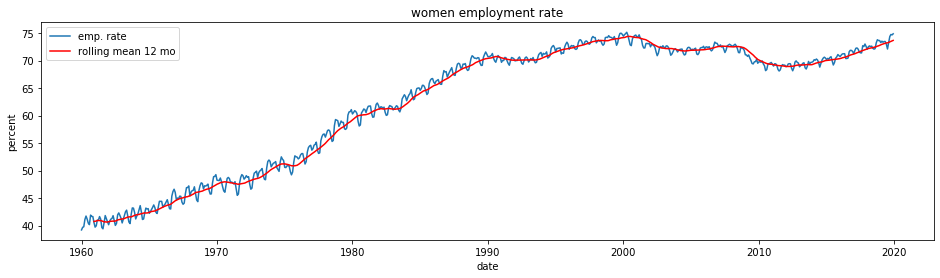

In [9]:
plt.figure(figsize=(16,4))
plt.plot(WmnEmpRate.date, WmnEmpRate.rate,label='emp. rate')
plt.plot(WmnEmpRate.date,WmnEmpRate.rolling(12).mean(), 'r',label='rolling mean 12 mo' )
plt.xlabel('date')
plt.ylabel('percent')
plt.title('women employment rate')
plt.legend()

There is clearly a trand in the mean, but the variance seems to be stable. There are many ways to remove the trend in the data.
For time series for which the waveform morphology is important, it's better to use a technique with minimal distorsion to the waveform; for example, a zero distortion high pass FIR filtering. Other methods such as differencing are as effective for many
applications.

Before performing any operations, let's look at some diagnostics.

c:\users\name\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


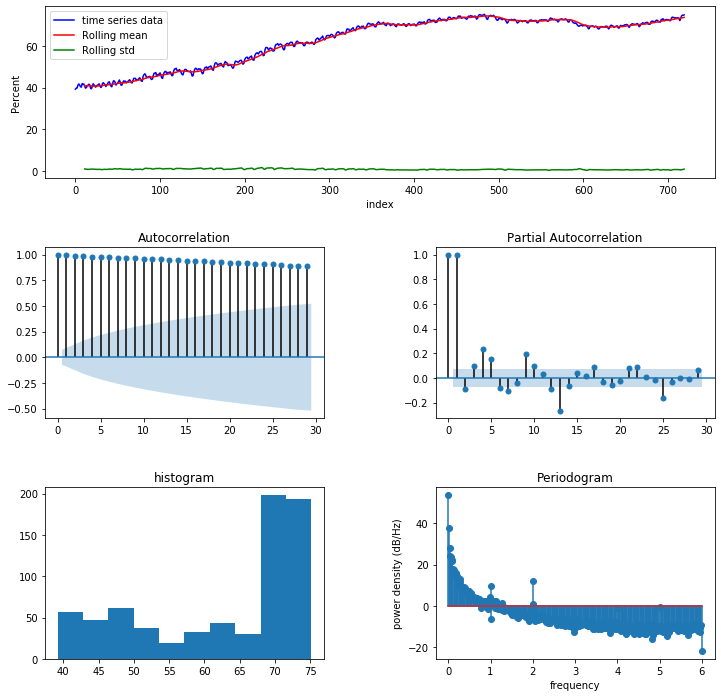

In [10]:
PlotTs(WmnEmpRate.rate)

## analysis
Observations:
- By using the rolling stats it is observed that the mean varies with time (trand) but the variance is quite stable (constant).
- Autocorrelation has a slow exponential decay indicating strong trend
- Partial autocorrelation show significant lags but hard to tell the seasonality
- histogram is highly left skewed, no other useful information
- Periodogram contains large amount of power in very low frequencies $1/f$, signifying existence of trend
- Periodogram has spikes at 1 year (12 months) and 2 year periods indicating seasonality in the data

We observe that the data has trend and seasonality by visually inspecting the time and frequency domain behavior of the data.
There fore, the time series is not **stationary**.

Next, we use the augmented Dickey-Fuller (ADF) test of unit root to understand whether the time series is stationary or not.

In [11]:
ADFTest(WmnEmpRate.rate)

adf            -2.48431
p-value         0.11934
num lags       20.00000
num obs       699.00000
1%             -3.43974
5%             -2.86568
10%            -2.56898
Fail to reject $H_0$ for 5% significance level, Not stationary!


Based on the ADF test the data is not stationary. The information about the trend is quite simply understood via a rolling mean. To understand other aspects of the data, we need to remove the trend. In other words, bringing data closer to stationarity. The followinf are some standard techniques

- Taking difference with lag 1
- Taking difference with lag for seasonality (e.g. 12 months etc.)

In [12]:
TsDiff1 = WmnEmpRate.rate.diff(1)

c:\users\name\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


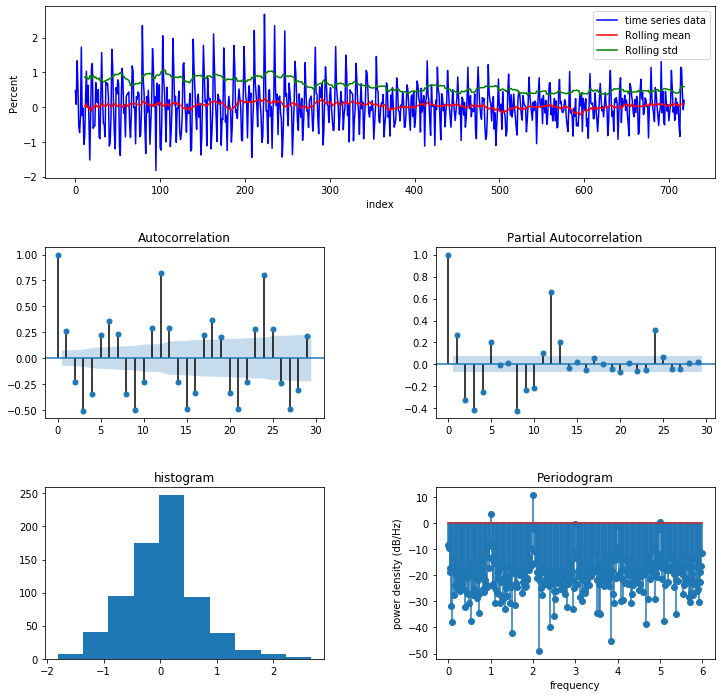

In [13]:
PlotTs(TsDiff1)

It is seen that after removing the trend using diff(1) the mean of the data is stationary and the std is stable too.
Acf and pacf, now, show the seasonal effect at 12 mo and 24 mo. the data is now more normally distributed. Periodogram shows two prominent spikes at 1 and 2 year period; the low frequencies associated with the trend is now gone.
Next, remove seasonality:

In [14]:
TsDiff12 = TsDiff1.diff(12)   # 12 months


c:\users\name\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


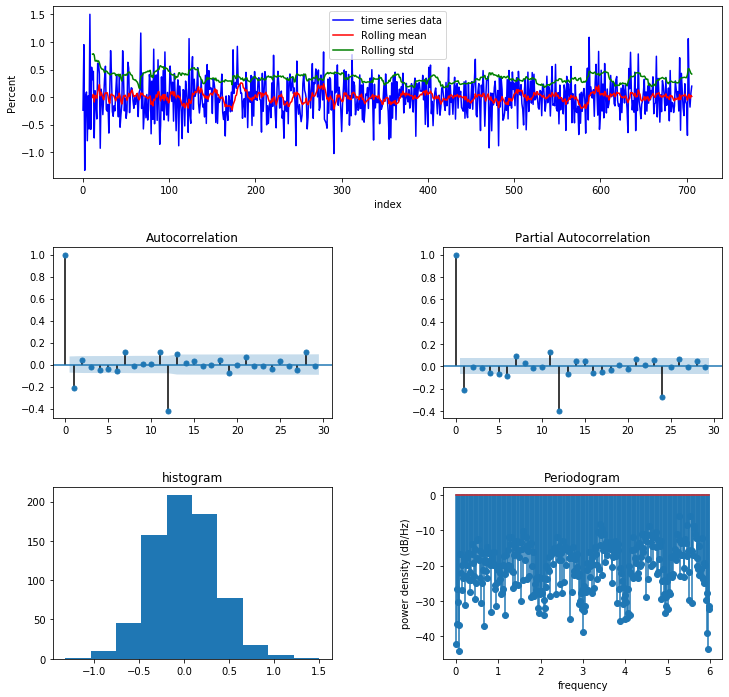

In [15]:
PlotTs(TsDiff12)

The resulting time series after removing trend and seasonality, our data is "stationary"

In [16]:
ADFTest(TsDiff12)

adf            -8.49455
p-value         0.00000
num lags       15.00000
num obs       691.00000
1%             -3.43985
5%             -2.86573
10%            -2.56900
Reject $H_0$ for 5% significance level, stationary!


Let's do some modelling. I'll try SARMA on the time series which is made stationary.

We have seen that we were able to make data stationary with differencing with lag 1 and 12 (removing trend and seasonality).

The ACF  plot shows that the stationary data has significant ACF at lag 1 with seasonality of the order 12. 
The PACF shows significant PACF at lags 1, 12 and 24. 
Therefore, I choose a SARIMA model with order (ar=1, diff=1, ma=1) and seasonal order (ar=1,diff=1,ma=1, period=12).
 The order of AR is determined by the number of significant pacf coeff and that for MA is determined from acf. In practice a cross validation should be performed to select the right model 
parameters.  
The residual should be pure random without any pattern or information left in it. Consequently, the residual must be a white 
noise process

$Residu \sim WN(0,\sigma_n^2)$

the probability plot (q-q plot) shows the distribution is very close to a normal distribution. The coefficients of the acf for
a WN process diminish quite rapidly (only at lag 0 is 1). 

# Modelling

## train-test split

In [17]:
train_pcnt = 0.75
TsData = WmnEmpRate.rate.dropna()
#TsData.reset_index(drop=True, inplace=True)
LenData = len(TsData)
TrainEnd = int(LenData*train_pcnt)

TsTrain = TsData[0:TrainEnd]
TsTest = TsData[TrainEnd:]

In [18]:
Mdl = sm.tsa.SARIMAX(TsTrain,order=(1,1,1), seasonal_order=(2,0,1,12))
MdlFit = Mdl.fit(disp=0)

In [19]:
MdlFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               rate   No. Observations:                  540
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                -121.800
Date:                            Mon, 17 Feb 2020   AIC                            255.600
Time:                                    17:11:14   BIC                            281.339
Sample:                                         0   HQIC                           265.667
                                            - 540                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7563      0.187      4.045      0.000       0.390       1.123
ma.L1         -0.8163      0.167     -4.895      0.000      -1.143      -0.489
ar.S.L12       1.0001      0.064     15.689      0.000       0.875       1.125
ar.S.L24      -0.0097      0.062     -0.157      0.875      -0.132       0.112
ma.S.L12      -0.7196      0.047    -15.465      0.000      -0.811      -0.628
sigma2         0.0876      0.005     18.453      0.000       0.078       0.097
===================================================================================
Ljung-Box (Q):                       58.24   Jarque-Bera (JB):                11.90
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

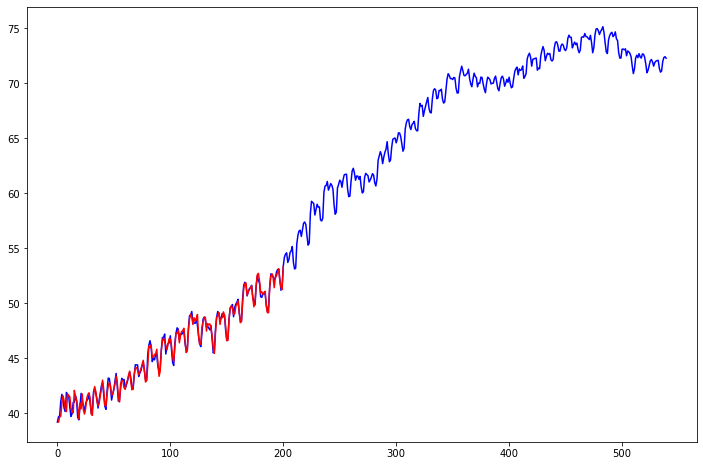

In [20]:
plt.figure(figsize=(12,8))
ax1= plt.subplot()
Yhat = MdlFit.predict(1,200,dynamic=False,ax=ax1);
ax1.plot(TsTrain,'b')
ax1.plot(Yhat,'r')


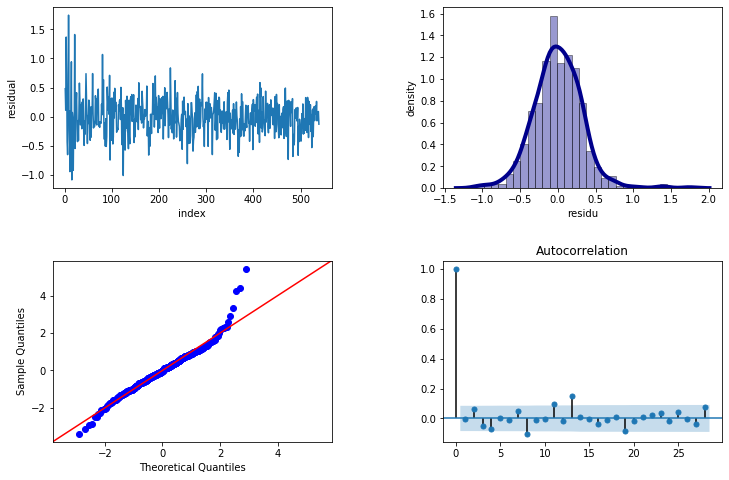

In [21]:
PlotDiagnostics(MdlFit.resid[1:])

## Ljung-Box Test
To be more systematic, we can use Ljung-Box test to acertain whther the residue is of WN.

- $H_0$: data is WN
- $H_a$ data has serial correlation

In [22]:
ljb, pVal = sm.stats.acorr_ljungbox(MdlFit.resid[1:], lags=[12])
print("ljb = %f,  p-val = %f" %(ljb,pVal))

ljb = 18.219958,  p-val = 0.109173


c:\users\name\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


p-val > 0.05 => fail to reject the H0 => residual is WN (up to lags 12!)

## Forecat into future

In [23]:
# Forecast
fc = MdlFit.forecast(len(TsTest), alpha = 0.05)  # 95% conf

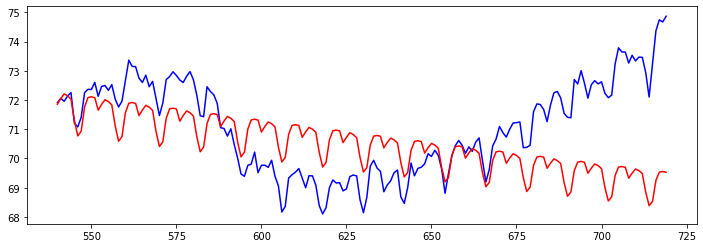

In [24]:
plt.figure(figsize=(12,4))
plt.plot(TsTest,'b')
plt.plot(fc,'r')


## Discussion

The test result shows that even though there are deviations this amount is rather samll and the model perform reseanoably well 
given that no hyper parameter tuning have been performed. Additionally, a cross validation should be pefromed to obtain a robust estimate of the test error.
The data has strong seasonality; it seems that the model learned the seasonal variation very well but fails to capture the trend as accurately. 

In [503]:
mean_absolute_error(TsTest,fc)

1.4564910715933286

In [504]:
np.sqrt(mean_squared_error(TsTest,fc))

1.8665795442943327

#TODO

- Model selection, hyper parameter tuning
- Cross velidation for test error estimate
- forecat error, conf interval
- add MAPE, MSAE metrics
- There's instability in prediction at index 0 => investigate